Welcome to this Machine Learning tutorial. To work the examples, you’ll need jupyter notebook. We are using a docker image that come with all packages preinstalled.
In the info card and description of the video there is a step by step tutorial of how to setup an environment like the one in this tutorial.

Scikit-Learn
There are several Python libraries which provide solid implementations of a range of machine learning algorithms. For this tutorial we will use Scikit-Learn, one of the best known, it provides efficient versions of a large number of common algorithms.

Model Selection
In principle, model selection is very simple: after choosing a model and its hyperparameters, we can estimate how effective it is by applying it to some of the training data and comparing the prediction to the known value.
Let's demonstrate the naive approach to selection using the Iris dataset, which famously analyzed by Ronald Fisher in 1936. We will start by loading the data.

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

Next we choose a model and hyperparameters. Here we'll use a k-neighbors classifier with n_neighbors=1. This is a very simple and intuitive model that says the label of an unknown point is the same as the label of its closest training point.

In [2]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

Now let's hold back some subset of the data from the training of the model, and then use this holdout set to check the model performance. This splitting can be done using the train_test_split utility in Scikit-Learn.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                  train_size=0.5)

# fit the model on one set of data
model.fit(X1, y1)

# evaluate the model on the second set of data
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)


0.9066666666666666

The nearest-neighbor classifier is about 90% accurate on this hold-out set. The hold-out set is similar to unknown data, because the model has not "seen" it before.

Model validation via cross-validation
cross-validation is to do a sequence of fits where each subset of the data is used both as a training set and as a validation set.
Here we do two validation trials, alternately using each half of the data as a holdout set. Using the split data from before, we could implement it like this


In [4]:
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.96, 0.9066666666666666)

What comes out are two accuracy scores, which we could combine (by, say, taking the mean) to get a better measure of the global model performance. 

Here we split the data into five groups, and use each of them in turn to evaluate the model fit on the other 4/5 of the data.

In [5]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, cv=5)

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

For example, we might wish to go to the extreme case in which our number of folds is equal to the number of data points: that is, we train on all points but one in each trial. This type of cross-validation is known as leave-one-out cross validation, and can be used as follows

In [6]:
from sklearn.model_selection import LeaveOneOut
scores = cross_val_score(model, X, y, cv=LeaveOneOut())
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Because we have 150 samples, the leave one out cross-validation yields scores for 150 trials, and the score indicates either successful (1.0) or unsuccessful (0.0) prediction. Taking the mean of these gives an estimate of the error rate

In [7]:
scores.mean()

0.96

Selecting the Best Model
Now that we've seen the basics of validation and cross-validation, we will go into a litte more depth regarding model selection and selection of hyperparameters.

Validation curves in Scikit-Learn
Let's look at an example of using cross-validation to compute the validation curve for a class of models.

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

Now let's create some data to which we will fit our model

In [9]:
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

We can now visualize our data, along with polynomial fits of several degrees

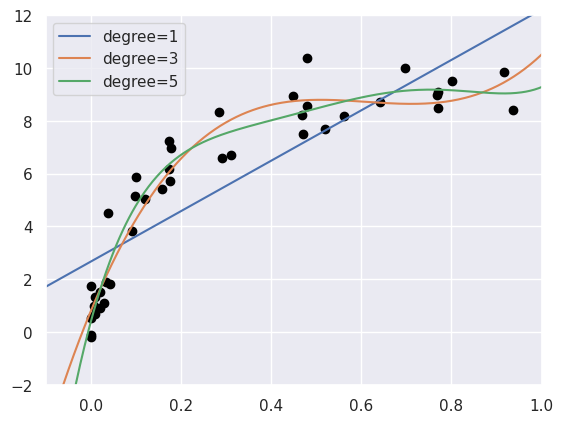

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot formatting

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

We can make progress in this by visualizing the validation curve for this particular data and model; this can be done straightforwardly using the validation_curve convenience routine provided by Scikit-Learn.

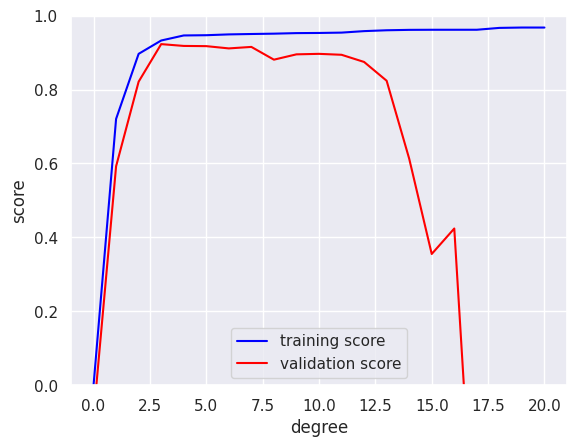

In [11]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          param_name = 'polynomialfeatures__degree', param_range = degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

This shows precisely the qualitative behavior we expect: the training score is everywhere higher than the validation score; the training score is monotonically improving with increased model complexity; and the validation score reaches a maximum before dropping off as the model becomes over-fit.

From the validation curve, we can read-off that the optimal trade-off between bias and variance is found for a third-order polynomial; we can compute and display this fit over the original data as follows

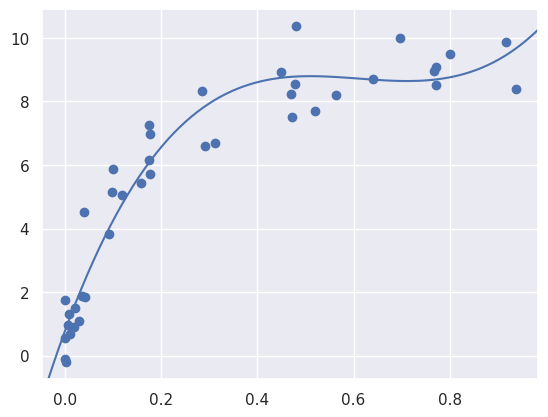

In [12]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

Notice that finding this optimal model did not actually require us to compute the training score, but examining the relationship between the training score and validation score can give us useful insight into the performance of the model.

Learning Curves
One important aspect of model complexity is that the optimal model will generally depend on the size of your training data. For example, let's generate a new dataset with a factor of five more points

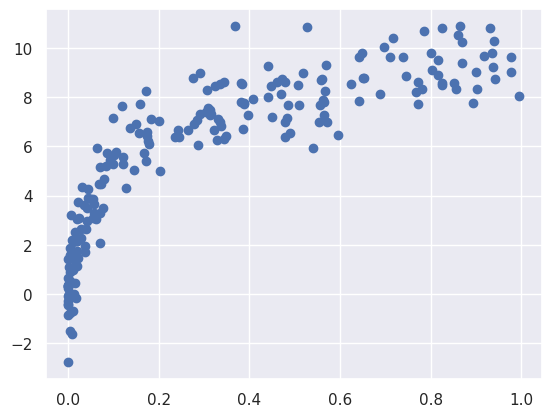

In [13]:
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

We will duplicate the preceding code to plot the validation curve for this larger dataset; for reference let's over-plot the previous results as well

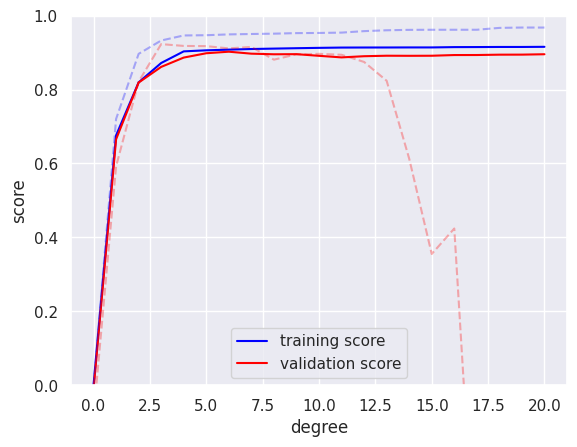

In [14]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
                                          param_name = 'polynomialfeatures__degree', param_range = degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

The solid lines show the new results, while the fainter dashed lines show the results of the previous smaller dataset.

Learning curves in Scikit-Learn
Scikit-Learn offers a convenient utility for computing such learning curves from your models; here we will compute a learning curve for our original dataset with a second-order polynomial model and a ninth-order polynomial

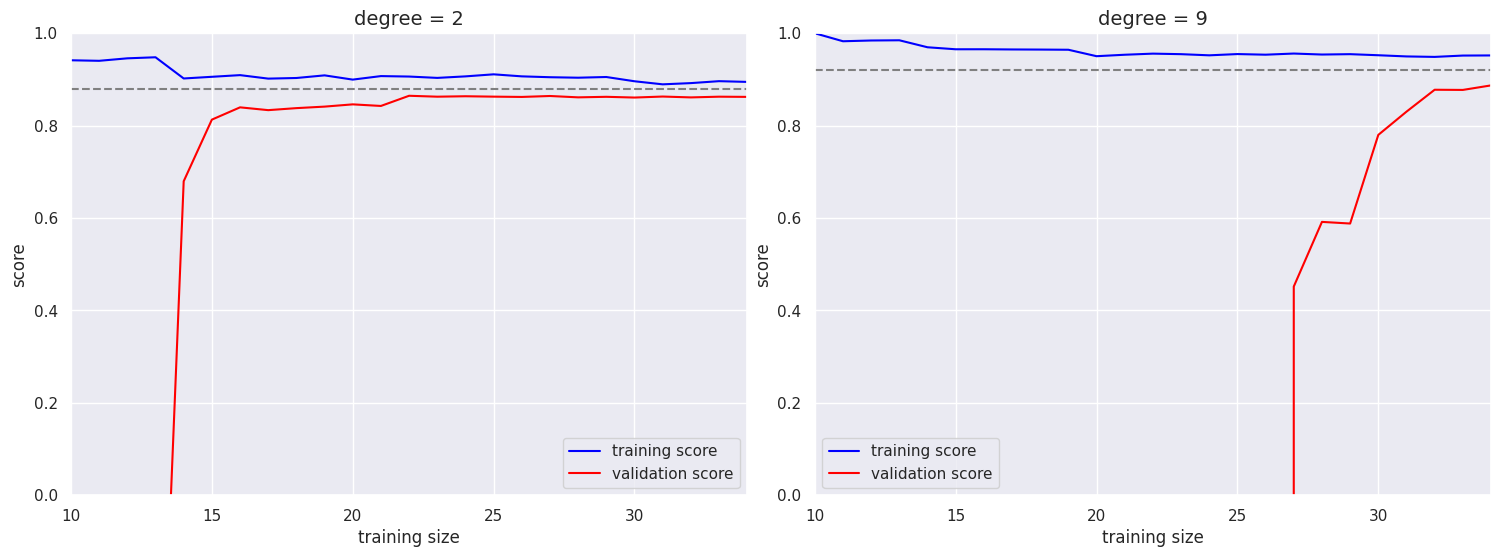

In [15]:
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X, y, cv=7,
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

This is a valuable diagnostic, because it gives us a visual depiction of how our model responds to increasing training data.

Validation in Practice: Grid Search
Here is an example of using grid search to find the optimal polynomial model. We will explore a three-dimensional grid of model features; namely the polynomial degree, the flag telling us whether to fit the intercept, and the flag telling us whether to normalize the problem. This can be set up using Scikit-Learn's GridSearchCV meta-estimator

In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=10)



Notice that like a normal estimator, this has not yet been applied to any data. Calling the fit() method will fit the model at each grid point, keeping track of the scores along the way

In [17]:
grid.fit(X, y);

Now that this is fit, we can ask for the best parameters as follows:

In [18]:
grid.best_params_

{'linearregression__fit_intercept': False, 'polynomialfeatures__degree': 4}

Finally, if we wish, we can use the best model and show the fit to our data using code from before

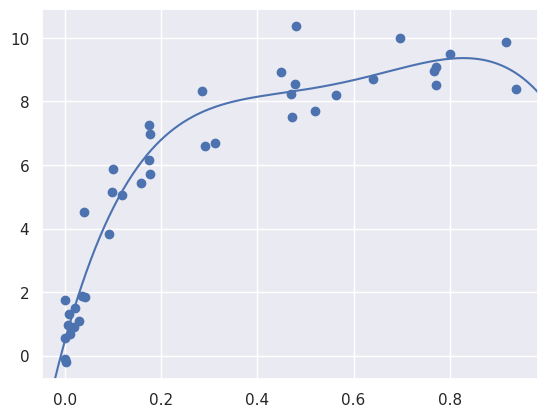

In [19]:
model = grid.best_estimator_

plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);